In [4]:
%matplotlib inline

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve , auc
from nltk.stem.porter import PorterStemmer

In [6]:
con = sqlite3.connect('C:/Users/Admin/Desktop/summer intern/archive_4/database.sqlite')

In [7]:
#filtering only positive and negative reviews i.e.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

In [8]:
#give reviews with score>3 a positive rating , and reviews with a score<3 as negative rating
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

#changing review with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [9]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
#DATA CLEANING : DEduplication

display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3 AND UserId="ABXLMWJIXXAIN"
ORDER BY ProductID
""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ..."
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...


In [11]:
#sorted_data according to productId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0 , ascending=True)

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first' , inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [14]:
display=pd.read_sql_query(""" 
SELECT *
FROM Reviews
WHERE Score !=3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries
print(final.shape)
#how many positive and negative review are present in out dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [17]:
#Text Preprocessing 
final['Text'].iloc[3200]

"When I opened the cookie tin, the sweet smell sent my senses into overdrive.<br /><br />I ate one on the spot.<br /><br />And then I ate another.<br /><br />David's Cookies sent my taste buds on an adventure. The delicious flavors included in the cookie tin were Chocolate Chunk, Peanut Butter, Oatmeal Raisin, Macadamia White Chip, and Double Chocolate Chunk. I was taken back to the days of eating my grandmother's homemade cookies. My favorites have to be Macadamia White Chip and Peanut Butter, although all of the cookies are wonderfully yummy.<br /><br />The only downside to David's Cookies is that they are somewhat expensive."

In [18]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Admin\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [19]:
stop=set(stopwords.words('english'))#set of stop words
 #import nltk  (if you have problem with stop words download it from nltk)
 #nltk.download('stopwords')

sno=nltk.stem.SnowballStemmer('english') #set of snow ball stemmers in english

def cleanhtml(sentence): #function to clean html tags in a sentence
    cleannr=re.compile('<.*?>')
    cleantext=re.sub(cleannr,'',sentence)
    return cleantext

def cleanpunc(sentence) : #function to clean punctuation in the sentence
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned

print(stop)
print('**' * 50)
print(sno.stem('taste'))

{'haven', 'their', 'hasn', 'was', 'both', 'd', "don't", 'own', 'same', "mustn't", 'themselves', 'don', "won't", 'yours', 'only', 'didn', 'why', 'further', 'how', "couldn't", 'too', 'is', 'but', 'now', "you're", 'each', 'here', 'this', 'and', 'no', 'very', 'do', 'doing', 's', 'i', 'until', 'shan', 'should', 'of', 'they', "aren't", 'on', 'she', 'or', 'then', 'some', 'after', 'those', "weren't", "hadn't", 'out', "should've", 'into', 'once', 'our', 'more', 'it', 'were', 'has', 'through', 'being', 'below', 'because', "she's", "isn't", 'them', 'few', 'so', 'its', 'ours', 'o', 'he', 'ain', 'doesn', "mightn't", "you'd", 'a', 'before', 'himself', 'there', 'won', 'whom', 'most', 'mustn', 'your', 'hadn', 'be', 'as', "you've", 'an', 'we', 'wouldn', 'between', "shan't", 'over', 'if', "that'll", 'while', 'aren', 'nor', 'from', 'against', 'needn', 'such', "shouldn't", 'weren', "haven't", 'what', 'my', 'than', 'yourself', 'just', 'which', 'not', "wasn't", 'had', 'are', 'him', 'will', "didn't", 'can', 

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[200]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[500]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[2000]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[3900]
print(sent_4900)
print("="*50)

You asked for my review of this purchase already, I said fast shipping and good product. Do not bother me with these reviews any more, if i have a problem i will let you know. I will stop using amozon in the future if you don't leave me alone.
As many other reviewers have suggested, the best way to use this trap is NOT to bury it, just simply tamp the ground over the tunnel and make 2 slots for the jaws of the trap. It never misses, when it trips, you have one less critter ruining your lawn!
Check with your Vet, but start your dogs off right and keep their joints flexible.  You will sure be glad you did as you watch your loved pet enjoy the latter stages of their lives with more mobility.  Worth the cost.  Check with your Vet before you begin giving these supplements to your dog on a daily basis.
Modeled after York Peppermint Patties, these mints are a perfect match of chocolate and sweet.  The honey filling is a bit thinner and sweeter than most mints this style, but you can tell all 

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_1000)

As many other reviewers have suggested, the best way to use this trap is NOT to bury it, just simply tamp the ground over the tunnel and make 2 slots for the jaws of the trap. It never misses, when it trips, you have one less critter ruining your lawn!


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

You asked for my review of this purchase already, I said fast shipping and good product. Do not bother me with these reviews any more, if i have a problem i will let you know. I will stop using amozon in the future if you don't leave me alone.
As many other reviewers have suggested, the best way to use this trap is NOT to bury it, just simply tamp the ground over the tunnel and make 2 slots for the jaws of the trap. It never misses, when it trips, you have one less critter ruining your lawn!
Check with your Vet, but start your dogs off right and keep their joints flexible.  You will sure be glad you did as you watch your loved pet enjoy the latter stages of their lives with more mobility.  Worth the cost.  Check with your Vet before you begin giving these supplements to your dog on a daily basis.
Modeled after York Peppermint Patties, these mints are a perfect match of chocolate and sweet.  The honey filling is a bit thinner and sweeter than most mints this style, but you can tell all 

In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_0 = decontracted(sent_0)
print(sent_0)


You asked for my review of this purchase already, I said fast shipping and good product. Do not bother me with these reviews any more, if i have a problem i will let you know. I will stop using amozon in the future if you do not leave me alone.


In [25]:
sent_4900 = re.sub("\S*\d\S*", "", sent_4900).strip()
print(sent_4900)

Modeled after York Peppermint Patties, these mints are a perfect match of chocolate and sweet.  The honey filling is a bit thinner and sweeter than most mints this style, but you can tell all the ingredients are natural.  The thin layer of gooey honey complements the unsweetened chocolate beautifully.  I highly recommend this tasty treat!


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)

You asked for my review of this purchase already I said fast shipping and good product Do not bother me with these reviews any more if i have a problem i will let you know I will stop using amozon in the future if you do not leave me alone 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above reviews
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:53<00:00, 1238.98it/s]


In [29]:
## Similartly you can do preprocessing for review summary also.

from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

  0%|                                                                           | 221/364171 [00:00<02:45, 2197.22it/s]C:\Users\Admin\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
  6%|████▍                                                                    | 22421/364171 [00:11<02:40, 2123.60it/s]C:\Users\Admin\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:01<00:00, 2009.57it/s]


In [30]:
preprocessed_reviews[2000]

'check vet start dogs right keep joints flexible sure glad watch loved pet enjoy latter stages lives mobility worth cost check vet begin giving supplements dog daily basis'

In [31]:
preprocessed_summary[2000]

'start right'

In [32]:

#BoW
count_vect = CountVectorizer() 
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[500:510])
final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['acception', 'acceptional', 'accepts', 'acces', 'accesesible', 'accesible', 'accesories', 'accesory', 'access', 'accessable']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


In [33]:
#
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203034)
the number of unique words including both unigrams and bigrams  203034


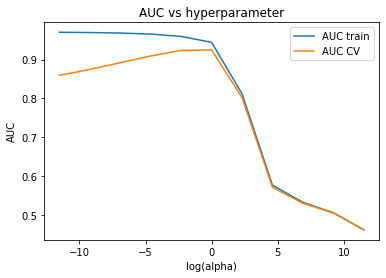

optimal alpha for which auc is maximum :  1


In [35]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
X=preprocessed_reviews

y=np.array(final['Score'])
count_vect=CountVectorizer()
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
final_Xtr=count_vect.fit_transform(X_tr)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)
auc_train=[]
auc_cv=[]
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    pred=mnb.predict_proba(final_Xcv)[:,1]
    pred1=mnb.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred1))
    auc_cv.append(roc_auc_score(y_cv,pred))
    
optimal_alpha= alpha_values[auc_cv.index(max(auc_cv))]
alpha_values=[math.log(x) for x in alpha_values]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha_values, auc_train, label='AUC train')
ax.plot(alpha_values, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

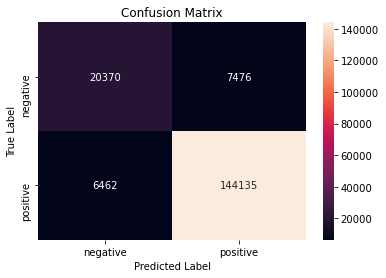

In [36]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

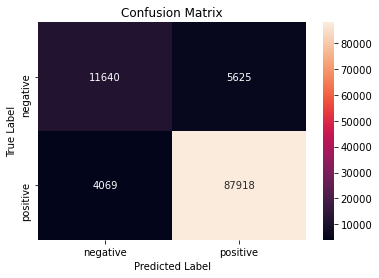

In [37]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [38]:

# Please write all the code with proper documentation
model=MultinomialNB(alpha=1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_ #log probability of features given a class
feature_names = count_vect.get_feature_names()
negative_features = np.argsort(features[0])[::-1] #Returns the indices that would sort an array
positive_features = np.argsort(features[1])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
not
like
good
great
one
taste
product
tea
flavor
love


In [39]:

# Please write all the code with proper documentation
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
like
product
would
taste
one
good
no
coffee
flavor


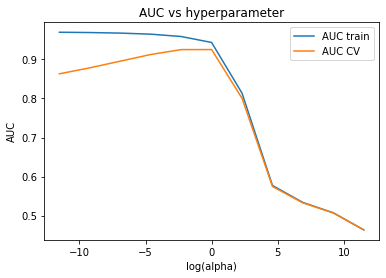

optimal alpha for which auc is maximum :  1


In [40]:
#Applying Multinomial Naive Bayes on BOW
# Please write all the code with proper documentation
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
X=preprocessed_reviews

y=np.array(final['Score'])
count_vect=CountVectorizer()
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
final_Xtr=count_vect.fit_transform(X_tr)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)
auc_train=[]
auc_cv=[]
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    pred=mnb.predict_proba(final_Xcv)[:,1]
    pred1=mnb.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred1))
    auc_cv.append(roc_auc_score(y_cv,pred))
    
optimal_alpha= alpha_values[auc_cv.index(max(auc_cv))]
alpha_values=[math.log(x) for x in alpha_values]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha_values, auc_train, label='AUC train')
ax.plot(alpha_values, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

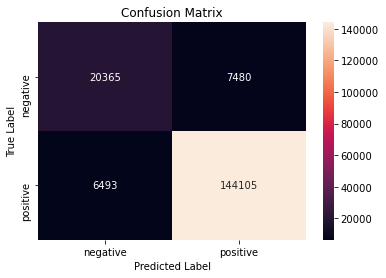

In [42]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

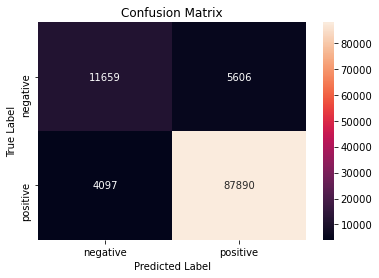

In [43]:
#Confusion matrix using heatmap test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [44]:
#Top 10 features of positive reviews from BOW
# Please write all the code with proper documentation
model=MultinomialNB(alpha=1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_
feature_names = count_vect.get_feature_names()
negative_features = np.argsort(features[0])[::-1]
positive_features = np.argsort(features[1])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
not
like
good
great
one
taste
product
tea
love
flavor


In [45]:
#Top 10 features of negative review from BOW
# Please write all the code with proper documentation
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
not
like
would
product
taste
one
good
no
flavor
coffee
